Two basic types of ** Recommender systems ** that are used are ** Content Based ** and ** Collaborative Filtering(CF) **. Content Based systems use the knowledge of the items/products to come up with the recommendations. 
Whereas ** Collaborative Filtering(CF) ** produces recommendations based on the knowledge of user interaction with the product/items.Collaborative filtering is done using two ways, one is ** Memory Based ** and other is ** Model based **. 

In this writeup, we will compare output from memory-based CF,model-based CF and third approach which uses Machine Learning algorithm ** Stochastic gradient descent ** to train the model for prediction.RMSE and movie recommendations for all the approaches will be compared.

In [2]:
"""
Below are some of the helper functions used for analyzing of various recommenders
"""
##Root Mean Squared Error. We will conside only non-zero ratings
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    
    return sqrt(mean_squared_error(prediction, ground_truth))

##Predit function to find user-user similarity and item-item similarity. User bias is removed by adjusting the 
##mean user bias before predicting ratings
def predict(ratings, similarity, type='user',epsilon=1e20):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])  
    return pred

##
##Find the top-k movie names based on the ordered ratings 
##
def top_k_movies_byuser(prediction, mapper, user_idx, k=6):
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]




##Predict the ratings using dot product of the latent features for users and items 
def predictionSGD(P,Q):
    return np.dot(P.T,Q)

# Load movie data
idx_to_movie = {}
with open('ml-100k/u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]

print(len(idx_to_movie))

1682


## Memory based Collorative Filtering
Memory based collaborative filtering has again two types , one is ** item based CF **(i.e Users who liked this item also liked …) and second is ** user based CF **(i.e Users who are similar to you also liked …)In the first approach,items are compared to find similar items and items are recommened accordingly. Likewise users are compared to find similar users and item interactions between similar users are used for recommendations.
Distance metric that is considered in this case is "Cosine Similarity"


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances

trainRMSE = []
testRMSE = []

header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
#print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)  

from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]



#Compute the cosine distance and 1-cosine distance yields cosine similarity.epsilon is used to handle the 
#divide by zero scenarios
epsilon=1e-9
user_similarity = (1-pairwise_distances(train_data_matrix, metric='cosine')) + epsilon
item_similarity = (1-pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon

user_idx = 16 

pred = predict(train_data_matrix, user_similarity, type='user')



userBasedTrainRMSE = rmse(pred, train_data_matrix)
userBasedTestRMSE = rmse(pred, test_data_matrix)

trainRMSE.append(userBasedTrainRMSE)
testRMSE.append(userBasedTestRMSE)

print('User-based CF MSE on train data: ' + str(userBasedTrainRMSE))
print('User-based CF MSE on test data: ' + str(userBasedTestRMSE)+"\n")
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(str(nearestMovies)  + "\n")

pred = predict(train_data_matrix, item_similarity, type='item')

itemBasedTrainRMSE = rmse(pred, train_data_matrix)
itemBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(itemBasedTrainRMSE)
testRMSE.append(itemBasedTestRMSE)


print('Item-based CF MSE on train data: ' + str(itemBasedTrainRMSE))
print('Item-based CF MSE on test data: ' + str(itemBasedTestRMSE)+"\n")
print("Movies recommended to user " + str(user_idx) + " are:")

nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(str(nearestMovies)  + "\n")



/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


User-based CF MSE on train data: 2.90053541817
User-based CF MSE on test data: 2.9561728668

Movies recommended to user 16 are:
['Hoop Dreams (1994)', 'Delicatessen (1991)', 'Toy Story (1995)', 'Striptease (1996)', "Smilla's Sense of Snow (1997)", 'Cold Comfort Farm (1995)']

Item-based CF MSE on train data: 3.09858790301
Item-based CF MSE on test data: 3.16207539546

Movies recommended to user 16 are:
['Escape to Witch Mountain (1975)', "Lover's Knot (1996)", 'Time Tracers (1995)', 'Collectionneuse, La (1967)', 'Paper, The (1994)', 'Slingshot, The (1993)']



In the above example, the RMSE for user based and item based models are given. We will run a similar test using the ** memory based (CF)** 

## Model  based Collaborative filtering
Model based collaborative filtering uses matrix factorization methods to find the hidden features from the given data. Singular Value Decomposition(SVD) is one such matrix factorization methods which we will explore below.We will use the SVD as the matrix factorization method to find the features in the vector space.


In [4]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 50)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

modelBasedTrainRMSE = rmse(X_pred, train_data_matrix)
modelBasedTestRMSE = rmse(X_pred, test_data_matrix)
trainRMSE.append(modelBasedTrainRMSE)
testRMSE.append(modelBasedTestRMSE)

print('Model-based CF MSE on train data: ' + str(modelBasedTrainRMSE))
print('Model-based CF MSE on test data: ' + str(modelBasedTestRMSE) + "\n")

print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(X_pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")

# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = X_pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print(ratings)


print(X_pred.shape)


/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Model-based CF MSE on train data: 2.07351160628
Model-based CF MSE on test data: 2.94706664635

Movies recommended to user 16 are:
['Toy Story (1995)', 'Gattaca (1997)', 'Taxi Driver (1976)', 'unknown', 'Good Will Hunting (1997)', 'First Knight (1995)']

   Actual Rating  Predicted Rating
0            4.0          2.837945
1            3.0          1.994064
2            4.0          3.736380
3            3.0          0.603447
4            3.0          1.592603
(943, 1682)


RMSE in the model based CF is not any better than the memory based model. Another big issue with the matrix factorization approach is that it does not work well with missing data.MovieLens dataset that is considered in this script has no Nan/missing values and thus the SVD worked. But in real-life scenario that is hardly the case.In the next section we will be using ** Stochastic Gradient Descent ** to update the missing features while minimizing loss function.

## Stochastic Gradient Descent

In this algorithm we need to find two low-rank matrices, user_feature(k * m) and movie_feature (k*n)
that makes prediction such that loss function is minimized.Update function for each step uses the formula menetioned in the given write-up.http://www.jmlr.org/proceedings/papers/v36/li14.pdf

We use regularized stochastic gradient descent to avoid overfitting and number of iterations are fixed. As the iterations increase RMSE is calculated to arrive at the optimum values of user and movie low rank matrix.


In [5]:
print(train_data_matrix.shape)

(943, 1682)


In [6]:
lmbda = 0.1 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data_matrix.shape  # Number of users and items
iterations = 100  # Number of epochs
gamma=0.01  # Learning rate

user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = train_data_matrix.nonzero()      
for iter in range(iterations):
    #print("iterations ",iter)
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - predictionSGD(user_feature[:,u],movie_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * ( e * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        movie_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix
    pred = predictionSGD(user_feature,movie_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)



In [7]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
pred=predictionSGD(user_feature,movie_feature)
sgdBasedTrainRMSE = rmse(pred, train_data_matrix)
sgdBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(sgdBasedTrainRMSE)
testRMSE.append(sgdBasedTestRMSE)

print('SGD CF MSE on train data: ' + str(sgdBasedTrainRMSE))
print('SGD CF MSE on test data: ' + str(sgdBasedTestRMSE) + "\n")

print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(pd.DataFrame(nearestMovies))
print("\n")

# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Train Predicted Rating","Test Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Train Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Test Predicted Rating"] = pred[user_idx,np.where(test_data_matrix[user_idx, :] > 0)[0]][0:5]
print(ratings)

SGD CF MSE on train data: 0.715195367929
SGD CF MSE on test data: 0.985570377192

Movies recommended to user 16 are:
                                     0
0                     Wife, The (1995)
1                          Bent (1997)
2               Band Wagon, The (1953)
3                     Fear, The (1995)
4  Amazing Panda Adventure, The (1995)
5                 Men With Guns (1997)


   Actual Rating  Train Predicted Rating  Test Predicted Rating
0            4.0                3.412332               3.258586
1            3.0                3.095583               2.969613
2            4.0                3.443447               0.179003
3            3.0                2.976036               3.884278
4            3.0                2.523353               3.405198


# Implementing Restricted Boltzmann machine using Tensor Flow
** Restriced Boltzmann Machine ** is a two layered neural network used to generalize the process of recontructing the input using Contrastive Divergence. 

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Normalizing the ratings to be between 0 and 1
train_data_matrix_new = train_data_matrix/5

# Hyper paramters
#Number of nodes in the hidden layer
hiddenUnits = 20
#Learning rate
alpha = 1.0

visibleUnits = train_data_matrix.shape[1]
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

#Phase 1: Input Processing/Postive phase
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

#Phase 2: Reconstruction Phase
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [9]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

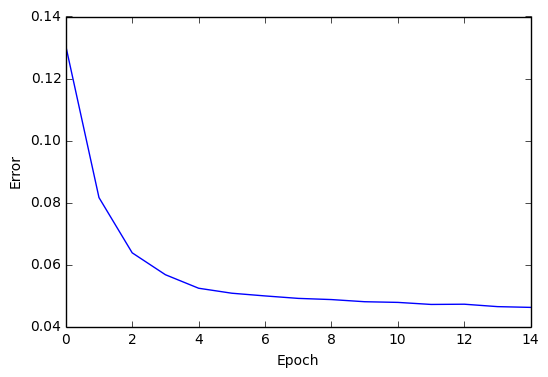

In [10]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(train_data_matrix_new), batchsize), range(batchsize, len(train_data_matrix_new), batchsize)):
        batch = train_data_matrix_new[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: train_data_matrix_new, W: cur_w, vb: cur_vb, hb: cur_nb}))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [11]:
def top_k_movies_byuserid(prediction, mapper, user_idx, k=6):
    return [{"movie":mapper[x],"prediction":prediction[0][x]} for x  in np.argsort(prediction)[0,:k]]



In [12]:
#Selecting the input user
inputUser = [train_data_matrix_new[user_idx]]
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print("Movies recommended to user " + str(user_idx))
nearestMovies = top_k_movies_byuserid(rec, idx_to_movie, user_idx)
print(pd.DataFrame(nearestMovies))


Movies recommended to user 16
                                               movie  prediction
0                            Butcher Boy, The (1998)    0.000057
1                                      Homage (1995)    0.000058
2                                      August (1996)    0.000064
3                              Lashou shentan (1992)    0.000069
4  Death in the Garden (Mort en ce jardin, La) (1...    0.000070
5                            Shadows (Cienie) (1988)    0.000071


## Model Performance
Let us do a simple plot to compare RMSE in all the 4 models we have considered.4 models considered here are the Memory based CF(user based and item based CF),Model Based CF(Singular Value Decomposition(SVD),Stochastic Gradient Descent.

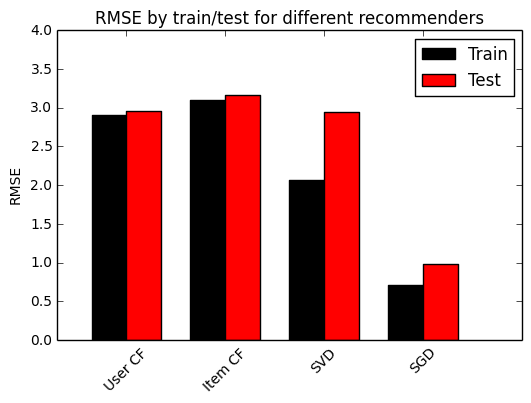

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

## the data
N = 4
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, trainRMSE, width,
                color='black'
                )

rects2 = ax.bar(ind+width, testRMSE, width,
                    color='red',
                    )

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,4)
ax.set_ylabel('RMSE')
ax.set_title('RMSE by train/test for different recommenders')
xTickMarks = ['User CF','Item CF','SVD','SGD']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test') )
plt.show()

# Conclusion
All the above models adopt different techniques to predict the movie ratings based on the existing data.Model performance is guaged with least Root Mean Square Error. Stochastic Gradient Descent outperforms other collaborative filtering methods with the least Root Mean Squared Error. In the next blog we will look at other models,including the hybrid models for the recommender systems.

## Reference

* http://www.jmlr.org/proceedings/papers/v36/li14.pdf

* http://online.cambridgecoding.com/notebooks/mhaller/implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent-4

* http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

